# Setup

In [1]:
%run ../Style_Sheet.ipynb

In [2]:
%matplotlib inline

In [3]:
%run ../FEAT_release/FEAT.ipynb
%run ../FEAT_release/FEAT_MOR.ipynb

In [4]:
warnings.simplefilter('ignore', UserWarning)

# Reduced Order Model Shape

## B738

Generate a reduced order model for a B738 using the BADA reference mass as the TOW and investigate its shape.

In [5]:
B738 = AircraftModel('B738')
generate_reduced_model(B738,25,**{'TOW':B738.m_ref})

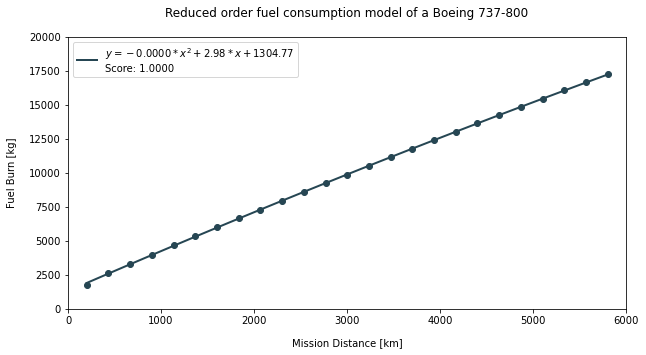

In [6]:
plt.figure(figsize=(10,5))
x_B738 = B738.reduced_model_samples.distance
y_B738 = B738.reduced_model_samples.fuel_burn
plt.scatter(x_B738,y_B738)
a1 = B738.reduced_fuel_a1.item()
a2 = B738.reduced_fuel_a2.item()
intercept = B738.reduced_fuel_intercept.item()
y_est_B738 = a1*x_B738**2 + a2*x_B738 + intercept
plt.plot(x_B738,y_est_B738,label='$y={:.4f}*x^2+{:.2f}*x+{:.2f}$\nScore: {:.4f}'.format(a1,a2,intercept,B738.reduced_fuel_score.item()))
plt.xlim(0,6000)
plt.ylim(0,20000)
plt.ylabel('Fuel Burn [kg]')
plt.xlabel('Mission Distance [km]')
plt.title('Reduced order fuel consumption model of a Boeing 737-800')
plt.legend();

The first thing to notice is that the flight at the lowest mission distance appears to deviate from the behavior of the rest of the curve. Let's explore this...

In [7]:
B738_extended_samples = B738.reduced_model_samples.copy()
extension = {'distance':[],'fuel_burn':[]}
for distance in np.arange(50,550,25):
    if distance != 200:
        profile,notes = simulate_flight(B738,distance,TOW=B738.m_ref)
        extension['distance'].append(distance)
        extension['fuel_burn'].append(profile_fuel_burn(profile))
B738_extended_samples = B738_extended_samples.append(pd.DataFrame(extension),sort=False)
B738_extended_samples = B738_extended_samples.sort_values('distance').reset_index(drop=True)

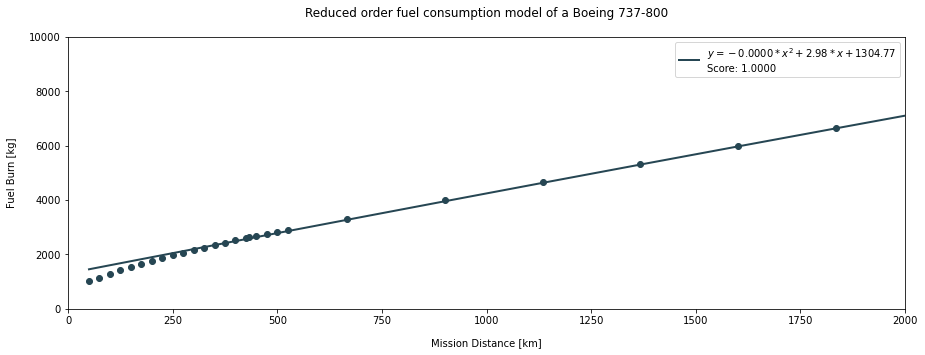

In [8]:
plt.figure(figsize=(15,5))
x_B738 = B738_extended_samples.distance
y_B738 = B738_extended_samples.fuel_burn
plt.scatter(x_B738,y_B738)
a1 = B738.reduced_fuel_a1.item()
a2 = B738.reduced_fuel_a2.item()
intercept = B738.reduced_fuel_intercept.item()
y_est_B738 = a1*x_B738**2 + a2*x_B738 + intercept
plt.plot(x_B738,y_est_B738,label='$y={:.4f}*x^2+{:.2f}*x+{:.2f}$\nScore: {:.4f}'.format(a1,a2,intercept,B738.reduced_fuel_score.item()))
plt.xlim(0,2000)
plt.ylim(0,10000)
plt.ylabel('Fuel Burn [kg]')
plt.xlabel('Mission Distance [km]')
plt.title('Reduced order fuel consumption model of a Boeing 737-800')
plt.legend();

The above plot shows more simulated points below 500 km. The simulated flights at very low mission distances form a steeper slope and a downward curve to a much greater degree than for the rest of the mission distances.

Next, we look at the cruise altitude achieved for different mission distances. Note that for very short flights, the aircraft may not reach the nominal aircraft cruise altitude as it must begin the decent to the destination airport before reaching the high altitude.

In [9]:
cruise_altitudes = {'distance':[],'cruise_altitude':[]}
for distance in B738_extended_samples.distance:
    profile,notes = simulate_flight(B738,distance,TOW=B738.m_ref)
    cruise_altitudes['distance'].append(distance)
    cruise_altitudes['cruise_altitude'].append(int(profile.altitude.max()))
cruise_altitudes = pd.DataFrame(cruise_altitudes)
cruise_altitudes.loc[:23]

,distance,cruise_altitude
0,50.000000,3000
1,75.000000,3000
2,100.000000,6000
3,125.000000,9000
4,150.000000,10000
5,175.000000,13000
6,200.000000,15000
7,225.000000,17000
8,250.000000,20000
9,275.000000,22000


We can see that the points that deviate in the previous plot correspond to the flights at which a lower cruise altitude are used. It follows that for increasing mission distances below 667 km, the maximum altitude of the aircraft is also increasing and therefore the fuel expended to reach the max altitude is higher. This leads to the higher slope at these smaller mission distances. At mission distances above about 667 km, the aircraft always climbs to 38,000 ft so the fuel expended in climb is the same. Let's explore another effect of cruise altitude on fuel burn...

### Cruise Altitude Effect

In [10]:
B738_alt_analysis = {'altitude':[],'1000 km':[],'2000 km':[],'3000 km':[]}
alts = np.arange(4000,40000,1000)
fuels = []
for distance in [1000,2000,3000]:
    for alt in alts:
        profile, notes = simulate_flight(B738,distance,TOW=B738.m_ref,max_altitude=alt)
        B738_alt_analysis[str(distance)+' km'].append(profile_fuel_burn(profile))
        if distance==1000:
            B738_alt_analysis['altitude'].append(alt)
B738_alt_analysis = pd.DataFrame(B738_alt_analysis)

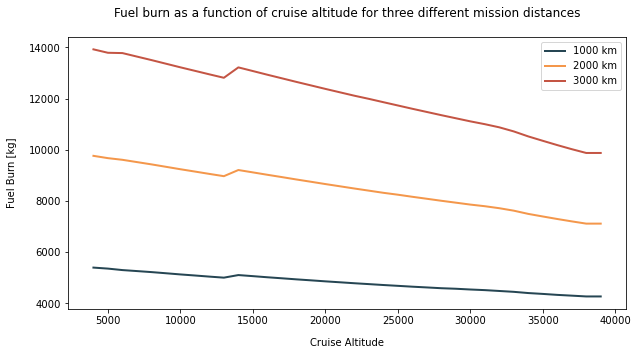

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
B738_alt_analysis.plot(x='altitude',y=['1000 km','2000 km','3000 km'],ax=ax)
plt.title("Fuel burn as a function of cruise altitude for three different mission distances")
plt.ylabel('Fuel Burn [kg]')
plt.xlabel('Cruise Altitude');

The general trend shows that increasing cruise altitude tends to decrese fuel consumption. This explains the downward curve of the reduced order model at lower mission distances... for low mission distances at which lower cruise altitudes are used, higher fuel consumption rates during cruise are found. As we increase the mission distance, the cruise altitude is increased and the fuel efficiency is improved. Thus we see a flattening of the reduced model curve.

An interesting behavior can be observed at cruise altitudes around 14,000 ft, however. Let's explore two flights: one at 13,000 ft cruise and one at 14,000 ft cruise...

Fuel burn: 13,217 kg


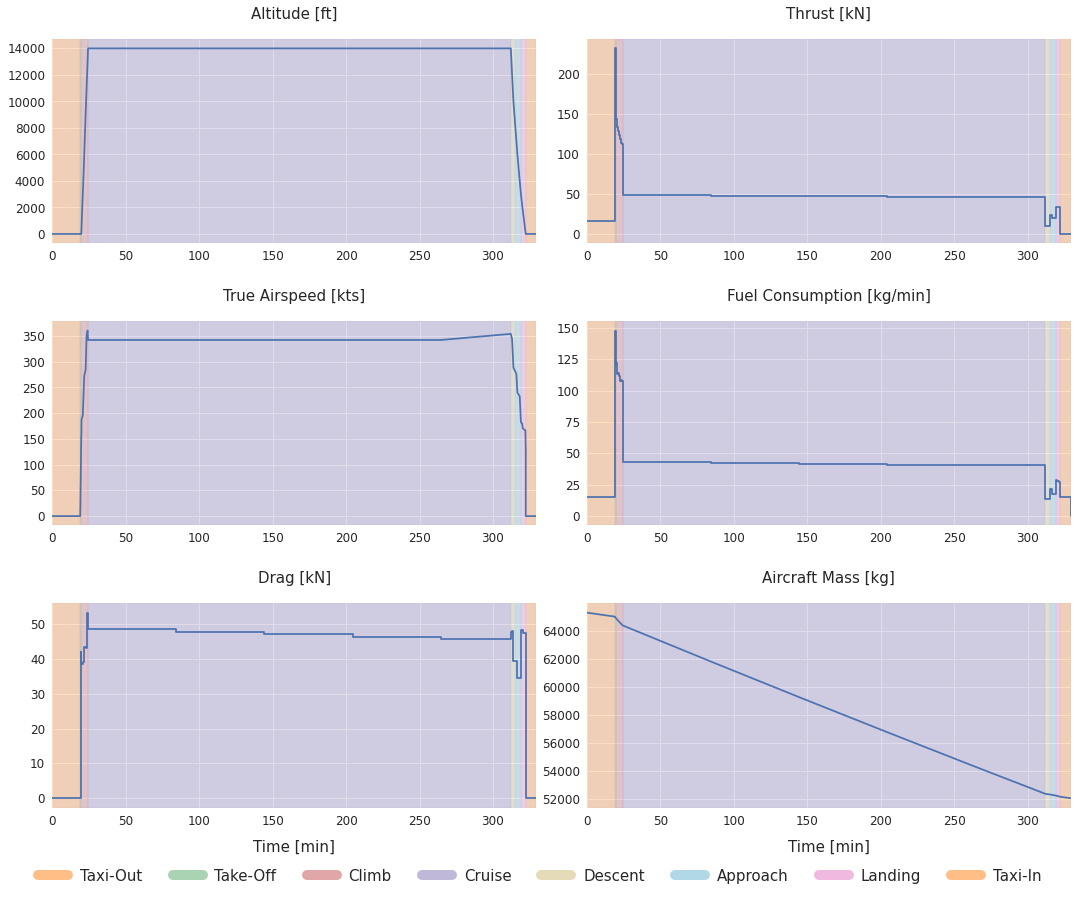

In [12]:
profile14,notes14 = simulate_flight(B738,3000,TOW=B738.m_ref,max_altitude=14000)
profile_viewer(profile14)

Fuel burn: 12,811 kg


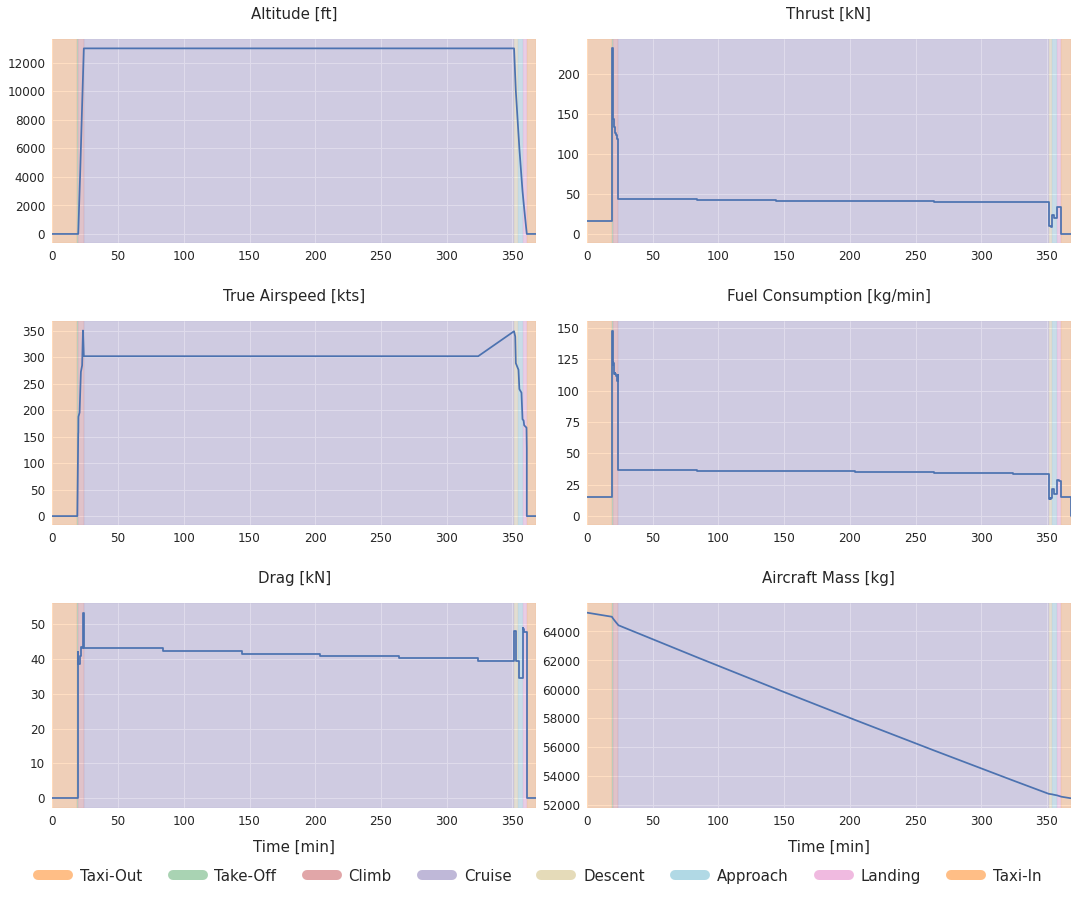

In [13]:
profile13,notes13 = simulate_flight(B738,3000,TOW=B738.m_ref,max_altitude=13000)
profile_viewer(profile13)

In [14]:
p14_fuel_rate = profile14.loc[profile14.phase=='Cruise','fuel'].mean()/(profile14.loc[profile14.phase=='Cruise','vtas'].mean()/32.3974) #[kg.km] (1 km/min = 32.3974 kts)
p13_fuel_rate = profile13.loc[profile13.phase=='Cruise','fuel'].mean()/(profile13.loc[profile13.phase=='Cruise','vtas'].mean()/32.3974) #[kg.km] (1 km/min = 32.3974 kts)
print('The mean cruise fuel flow rate is {:.2f} kg/km at 14,000 ft and {:.2f} kg/km at 13,000 ft.'.format(p14_fuel_rate,p13_fuel_rate))

The mean cruise fuel flow rate is 3.94 kg/km at 14,000 ft and 3.80 kg/km at 13,000 ft.


As can be seen from the plots above, when the aircraft has a maximum altitude below 14,000ft the cruise speed is much lower (~300 kts instead of ~350 kts). As shown in the cell above, this lower speed is more fuel efficient. This is why there is a local minimum of fuel consumption when the cruise altitude is just under 14,000ft. Thus, it follows that for very short flights, where the aircraft cruises at a much lower altitude and flies at a slower, more fuel-efficient speed.

The low speed below 14,000 ft is dictated by the BADA model. Of note, the ICAO holding speed limit below 14,000 ft is 230 knots (calibrated air speed), but the speed is limited to 250 kts in BADA. (https://www.skybrary.aero/index.php/Holding_Pattern#Standard_Holding_Pattern)

Now that the effect of cruise altitude is understood, let's remove the flights at mission distances where the cruise altitude is below the maximum 38,000 ft and look again at our reduced model

### Flight Phase Fuel Flows

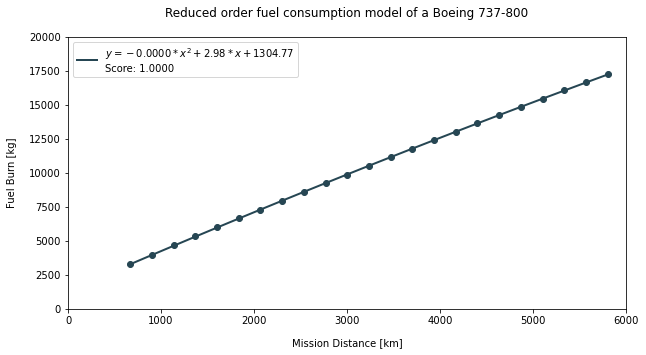

In [15]:
plt.figure(figsize=(10,5))
x_B738 = B738.reduced_model_samples.distance[2:]
y_B738 = B738.reduced_model_samples.fuel_burn[2:]
plt.scatter(x_B738,y_B738)
a1 = B738.reduced_fuel_a1.item()
a2 = B738.reduced_fuel_a2.item()
intercept = B738.reduced_fuel_intercept.item()
y_est_B738 = a1*x_B738**2 + a2*x_B738 + intercept
plt.plot(x_B738,y_est_B738,label='$y={:.4f}*x^2+{:.2f}*x+{:.2f}$\nScore: {:.4f}'.format(a1,a2,intercept,B738.reduced_fuel_score.item()))
plt.xlim(0,6000)
plt.ylim(0,20000)
plt.ylabel('Fuel Burn [kg]')
plt.xlabel('Mission Distance [km]')
plt.title('Reduced order fuel consumption model of a Boeing 737-800')
plt.legend();

Interestingly, we still observe a downward shape to the reduced order model. Theory suggests that since our TOW remains the same for each of the simulated flights, we should observe a linear trend. Let's look to the fuel consumption of each phase to explain this phenomenon...

In [16]:
profile, notes = simulate_flight(B738,1000,TOW=B738.m_ref)
profile["timedelta"] = -profile.time.diff(periods=-1)
profile['fuel_burned'] = profile.timedelta*profile.fuel
phase_fuels = profile[['phase','fuel_burned']].groupby('phase').sum().loc[['Taxi-Out', 'Take-Off', 'Climb', 'Cruise', 'Descent', 'Approach','Landing', 'Taxi-In']]
for distance in [2000,3000,4000]:
    profile, notes = simulate_flight(B738,distance,TOW=B738.m_ref)
    profile["timedelta"] = -profile.time.diff(periods=-1)
    profile['fuel_burned'] = profile.timedelta*profile.fuel
    phase_fuels = phase_fuels.merge(profile[['phase','fuel_burned']].groupby('phase').sum().loc[['Taxi-Out', 'Take-Off', 'Climb', 'Cruise', 'Descent', 'Approach','Landing', 'Taxi-In']],left_index=True,right_index=True,suffixes=('','_'+str(distance)+'km'))
phase_fuels.rename(columns={'fuel_burned':'fuel_burned_1000km'},inplace=True)
phase_fuels

,fuel_burned_1000km,fuel_burned_2000km,fuel_burned_3000km,fuel_burned_4000km
phase,,,,
Taxi-Out,283.404000,283.404000,283.404000,283.404000
Take-Off,122.732267,122.732267,122.732267,122.732267
Climb,1673.704869,1673.704869,1673.704869,1673.704869
Cruise,1751.461715,4602.109754,7368.364050,10067.414870
Descent,165.613358,161.260009,156.710241,151.955218
Approach,73.700844,72.715905,71.928454,71.319895
Landing,99.850043,97.216609,94.617214,92.036478
Taxi-In,104.412000,104.412000,104.412000,104.412000


It is clear that since the TOW is the same for all flights, the pre-cruise phase fuel consumption is also the same.

In [17]:
# Sum the fuel consumed for the post-cruise phases
phase_fuels.iloc[4:].sum()

fuel_burned_1000km    443.576245
fuel_burned_2000km    435.604523
fuel_burned_3000km    427.667908
fuel_burned_4000km    419.723592
dtype: float64

The above result shows that the post-cruise fuel consumption decreases with increasing mission distance. This is due to the fact that for a given TOW, a longer flight will burn more fuel and result in a lighter aircraft during the post-cruise phases. During this time, in order to maintain the predetermined rate of descent, a lower thrust setting is required. This contributes to the downward shape of the reduced order model.

The most basic aircraft fuel consumption model assumes a cruise-only flight. In such a case, a linear relationship between flight distance and fuel consumption is assumed. Let's look at the fuel consumption of just the cruise phase to see if it does in fact linearly scale with mission distance...

In [18]:
cruise_fuel = {'distance':[],'cruise_fuel':[]}
for distance in np.arange(1000,5000,100):
    profile, notes = simulate_flight(B738,distance,TOW=B738.m_ref)
    profile["timedelta"] = -profile.time.diff(periods=-1)
    cruise_fuel['distance'].append(distance)
    cruise_fuel['cruise_fuel'].append((profile.loc[profile.phase=='Cruise','timedelta']*profile.loc[profile.phase=='Cruise','fuel']).sum())
cruise_fuel = pd.DataFrame(cruise_fuel)
cruise_fuel.head()

,distance,cruise_fuel
0,1000,1751.461715
1,1100,2041.805441
2,1200,2331.604263
3,1300,2615.506096
4,1400,2899.416778


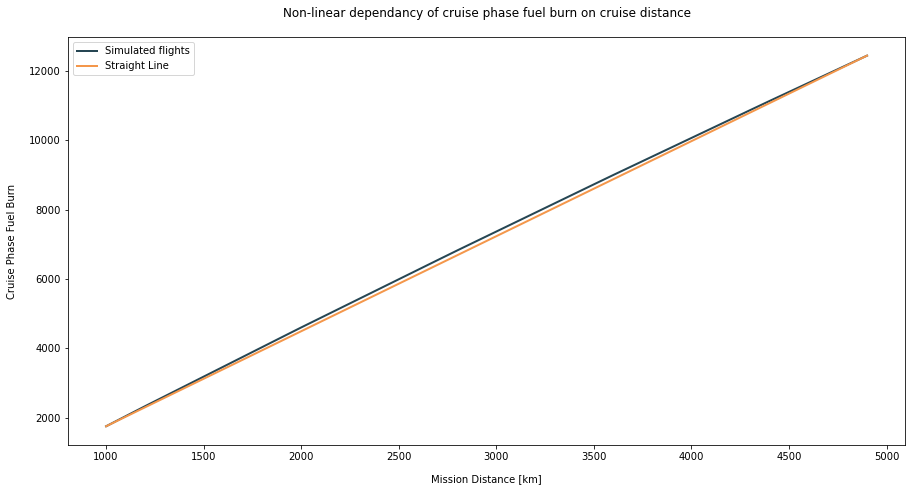

In [19]:
plt.figure(figsize=(15,7.5))
plt.plot(cruise_fuel.distance,cruise_fuel.cruise_fuel,label='Simulated flights')
plt.plot(cruise_fuel.iloc[[0,-1]]['distance'],cruise_fuel.iloc[[0,-1]]['cruise_fuel'],label='Straight Line')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Cruise Phase Fuel Burn')
plt.title('Non-linear dependancy of cruise phase fuel burn on cruise distance')
plt.legend();

The above graph demonstrates that cruise fuel does not linearly scale with mission distance, but instead increases at a decreasing rate. Let's look at cruise fuel flow rates to see why...

In [20]:
profile, notes = simulate_flight(B738,4000,TOW=B738.m_ref)
profile.loc[profile.phase=='Cruise']

,altitude,distance,time,phase,temperature,p,rho,a,vtas,vcas,mach,mass,thrust,drag,fuel,esf,rocd,pwc
30,38000,243.897934,39.827105,Cruise,216.65,20646.148921,0.331985,295.069494,447.38437,246.692688,0.78,63220.158864,40456.175254,40456.175254,38.454356,1.0,0.0,1.0
31,38000,1072.453788,99.827105,Cruise,216.65,20646.148921,0.331985,295.069494,447.38437,246.692688,0.78,60912.897493,39556.114207,39556.114207,37.598831,1.0,0.0,1.0
32,38000,1901.009641,159.827105,Cruise,216.65,20646.148921,0.331985,295.069494,447.38437,246.692688,0.78,58656.967620,38708.428116,38708.428116,36.793090,1.0,0.0,1.0
33,38000,2729.565495,219.827105,Cruise,216.65,20646.148921,0.331985,295.069494,447.38437,246.692688,0.78,56449.382242,37909.873703,37909.873703,36.034049,1.0,0.0,1.0
34,38000,3558.121349,279.827105,Cruise,216.65,20646.148921,0.331985,295.069494,447.38437,246.692688,0.78,54287.339324,37157.482524,37157.482524,35.318887,1.0,0.0,1.0


In the above table, notice that the fuel flow rate during cruise (the 'fuel' column) decreases through the flight. This is due to the fact that the aircraft mass decreases during flight as fuel is burned off. Therefore, less lift is required and the lower lift-induced drag of the aircraft in turn reduces the required thrust and fuel required to mainain the cruise altitude and speed. Thus, the average cruise fuel flow rate decreases with increasing mission distance. This explains the downward shape of the reduced order model.

### Fuel Payload Effect

Now let's look at the effect of fuel payload on the reduced order model shape...

A required parameter for calculating a flight's fuel consumption is the take-off weight of the aircraft. This depends on the amount of fuel required for the trip. Thus, the following cell computes the required trip fuel for each flight iteratively...

In [21]:
fuel_burns = {'distance':[],'tow':[],'fuel_burn':[]}
for distance in np.arange(1000,5200,200):
    diff=21
    fuel_load = 0
    initial_mass = B738.m_ref+fuel_load
    while abs(diff)>20:#The profile is considered a solution when the TOW difference is less than 20 kg
        profile, notes = simulate_flight(B738,distance,TOW=initial_mass)
        fuel_load = profile_fuel_burn(profile)
        diff = initial_mass - (B738.m_ref+fuel_load)
        initial_mass = B738.m_ref+fuel_load
    fuel_burns['distance'].append(distance)
    fuel_burns['tow'].append(profile.mass.max())
    fuel_burns['fuel_burn'].append(fuel_load)
fuel_burns = pd.DataFrame(fuel_burns)

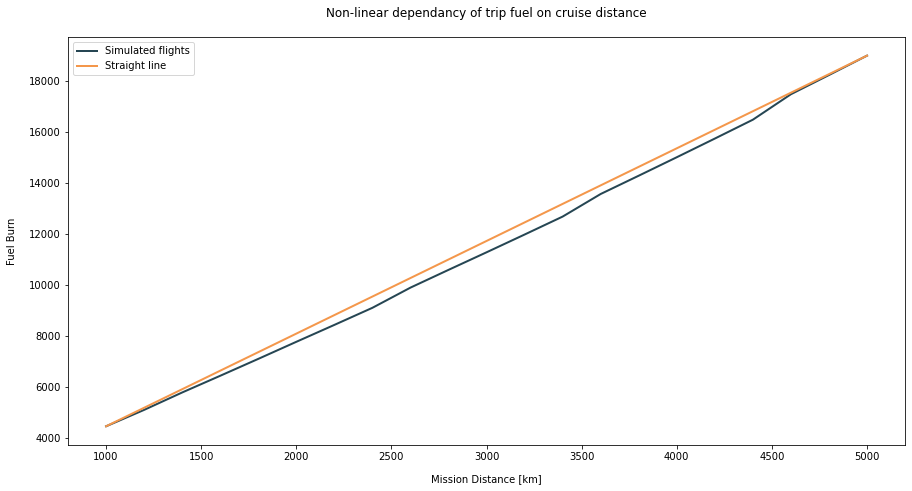

In [22]:
plt.figure(figsize=(15,7.5))
plt.plot(fuel_burns['distance'],fuel_burns['fuel_burn'],label='Simulated flights')
plt.plot(fuel_burns.iloc[[0,-1]]['distance'],fuel_burns.iloc[[0,-1]]['fuel_burn'],label='Straight line')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Fuel Burn')
plt.title('Non-linear dependancy of trip fuel on cruise distance')
plt.legend();

The above graph shows that the fuel consumption (which is by definition equal to the fuel load here) increases at an increasing rate as the mission distance increases. This is due to the fact that the additional weight of additional fuel on-board for longer mission distances increases the fuel consumption of the flight.

In [23]:
_ = fuel_burns.copy()
_.tow = round(_.tow/1e3,1)
_.fuel_burn = round(_.fuel_burn/1e3,1)
_.rename(columns={'distance':'Distance [km]','tow':'TOW [tons]','fuel_burn':'Fuel Burn [tons]'},inplace=True)
_

,Distance [km],TOW [tons],Fuel Burn [tons]
0,1000,69.8,4.5
1,1200,70.4,5.1
2,1400,71.1,5.8
3,1600,71.7,6.5
4,1800,72.4,7.1
5,2000,73.1,7.8
6,2200,73.7,8.4
7,2400,74.4,9.1
8,2600,75.2,9.9
9,2800,75.9,10.6


In [24]:
print('The maximum take-off weight of a B738 is {:.1f} tons.'.format(B738.m_max))

The maximum take-off weight of a B738 is 78300.0 tons.


The MTOW (maximum take-off weight) of a B738 is approximately 78 tons. We see from the fuel burns calculation that the aircraft TOW (take-off weight) is above the MTOW for the aircraft type at distances above 3,400 km. If we let the high fidelity model calculate the TOW independently, it will apply a MTOW constraint according to the value supplied by BADA. Let's set the MTOW constraint and review the behavior...

In [25]:
fuel_burns = {'distance':[],'tow':[],'fuel_burn':[]}
for distance in np.arange(1000,5200,200):
    diff=21
    fuel_load = 0
    initial_mass = B738.m_ref+fuel_load
    if distance<=3400:
        while abs(diff)>20: #The profile is considered a solution when the TOW difference is less than 20 kg
            profile, notes = simulate_flight(B738,distance,TOW=initial_mass)
            fuel_load = profile_fuel_burn(profile)
            diff = initial_mass - (B738.m_ref+fuel_load)
            initial_mass = B738.m_ref+fuel_load
    else:
        profile, notes = simulate_flight(B738,distance,TOW=B738.m_max)
        fuel_load = profile_fuel_burn(profile)
    fuel_burns['distance'].append(distance)
    fuel_burns['tow'].append(profile.mass.max())
    fuel_burns['fuel_burn'].append(fuel_load)
fuel_burns = pd. DataFrame(fuel_burns)

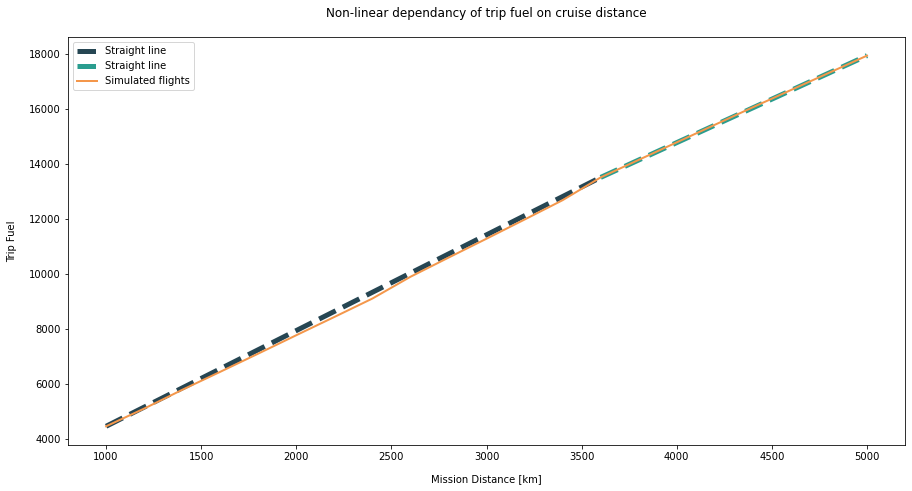

In [26]:
plt.figure(figsize=(15,7.5))
plt.plot(fuel_burns.iloc[[0,13]]['distance'],fuel_burns.iloc[[0,13]]['fuel_burn'],label='Straight line',linestyle='--',linewidth=5,c='C0')
plt.plot(fuel_burns.iloc[[13,-1]]['distance'],fuel_burns.iloc[[13,-1]]['fuel_burn'],label='Straight line',linestyle='--',linewidth=5,c='C3')
plt.plot(fuel_burns['distance'],fuel_burns['fuel_burn'],label='Simulated flights',linewidth=2,c='C1')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Trip Fuel')
plt.title('Non-linear dependancy of trip fuel on cruise distance')
plt.legend();

The above graph shows that the fuel load increases at an increasing rate as the mission distance increases up the the distance where the TOW is constrained to the maximum. Then, the fuel load increases linearly with mission distance.

### Final Reduced Order Model Summary

Now let's look at the final reduced order model for this aircraft...

In [27]:
generate_reduced_model(B738,25)

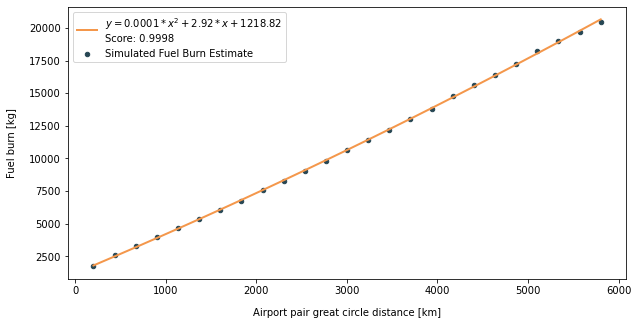

In [28]:
reduced_model_ac_viewer(B738)

The following effects contribute (although subtly) to the above reduced order model shape:
<br><br> <b>1.</b> The lowest point, corresponding to a mission distance of 200km falls below the regression line. This is due to the fact that at this distance, the aircraft does not climb to the maximum cruise altitude and thus burns less fuel during the demanding climb phase.
<br><br> <b>2.</b> At mission distances up to around 500 km, the fuel consumption increases at a decreasing rate with increasing mission distance. This is due to the fact that as the mission distance increases through this range, so does the cruise altitude. In general, higher cruise altitudes provide increased fuel efficiency during cruise.
<br><br> <b>3.</b> Up to a critical mission distance, the fuel consumption increases at an increasing rate with increasing mission distance. This is due to the fact that for higher mission distances, aircraft must carry additional fuel and this induces higher fuel consumption rates during the climb and cruise phases. <font color=red> It must be noted that this trend is very subtle for this particular aircraft. For some other aircraft, the effect of increased fuel loads may be more pronounced and lead to a greater upward curve. However, for other aircraft, the shape of the reduced model could curve downward in this range. This would be due to the fact that for increasing cruise intervals, the average cruise fuel consumption decreases since the aircraft mass (and subsequently drag) decreases throughout the flight.</font>
<br><br> <b>4.</b> Above the critical mission distance the fuel consumption increases nearly linearly with increasing mission distance. This is due to the fact that the TOW at these distances are constrained to the MTOW and the increasing fuel load effect is thus not present. However, the decreasing average fuel flow during cruise effect does exist here to a small extent.

## A321

Generate a reduced order model for a A321 using the BADA reference mass as the TOW and investigate its shape.

In [29]:
A321 = AircraftModel('A321')
generate_reduced_model(A321,25,**{'TOW':A321.m_ref})

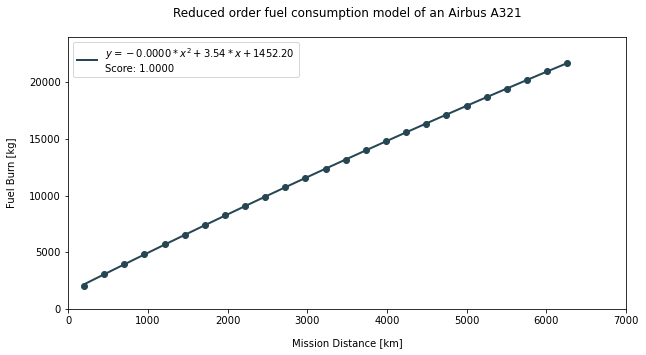

In [30]:
plt.figure(figsize=(10,5))
x_A321 = A321.reduced_model_samples.distance
y_A321 = A321.reduced_model_samples.fuel_burn
plt.scatter(x_A321,y_A321)
a1 = A321.reduced_fuel_a1.item()
a2 = A321.reduced_fuel_a2.item()
intercept = A321.reduced_fuel_intercept.item()
y_est_A321 = a1*x_A321**2 + a2*x_A321 + intercept
plt.plot(x_A321,y_est_A321,label='$y={:.4f}*x^2+{:.2f}*x+{:.2f}$\nScore: {:.4f}'.format(a1,a2,intercept,A321.reduced_fuel_score.item()))
plt.xlim(0,7000)
plt.ylim(0,24000)
plt.ylabel('Fuel Burn [kg]')
plt.xlabel('Mission Distance [km]')
plt.title('Reduced order fuel consumption model of an Airbus A321')
plt.legend();

The cruise altitude effect described previously is evident for the A321 as well

### Flight Phase Fuel Flows

In [31]:
cruise_fuel = {'distance':[],'cruise_fuel':[]}
for distance in np.arange(1000,5000,100):
    profile, notes = simulate_flight(A321,distance,TOW=A321.m_ref)
    profile["timedelta"] = -profile.time.diff(periods=-1)
    cruise_fuel['distance'].append(distance)
    cruise_fuel['cruise_fuel'].append((profile.loc[profile.phase=='Cruise','timedelta']*profile.loc[profile.phase=='Cruise','fuel']).sum())
cruise_fuel = pd.DataFrame(cruise_fuel)

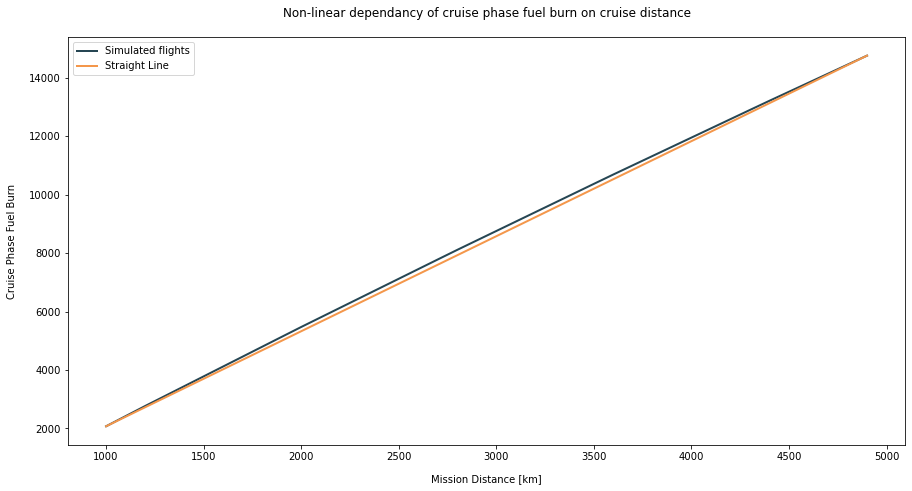

In [32]:
plt.figure(figsize=(15,7.5))
plt.plot(cruise_fuel.distance,cruise_fuel.cruise_fuel,label='Simulated flights')
plt.plot(cruise_fuel.iloc[[0,-1]]['distance'],cruise_fuel.iloc[[0,-1]]['cruise_fuel'],label='Straight Line')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Cruise Phase Fuel Burn')
plt.title('Non-linear dependancy of cruise phase fuel burn on cruise distance')
plt.legend();

As before, the above graph demonstrates that cruise fuel does not linearly scale with mission distance, but instead increases at a decreasing rate because the fuel flow rate during cruise reduces during the course of long flights. This results in a slightly downward curve.

### Fuel Payload Effect

In [33]:
fuel_burns = {'distance':[],'tow':[],'fuel_burn':[]}
for distance in np.arange(1000,6400,200):
    diff=21
    fuel_load = 0
    initial_mass = A321.m_ref+fuel_load
    while abs(diff)>20:#The profile is considered a solution when the TOW difference is less than 20 kg
        profile, notes = simulate_flight(A321,distance,TOW=initial_mass)
        fuel_load = profile_fuel_burn(profile)
        diff = initial_mass - (A321.m_ref+fuel_load)
        initial_mass = A321.m_ref+fuel_load
    fuel_burns['distance'].append(distance)
    fuel_burns['tow'].append(profile.mass.max())
    fuel_burns['fuel_burn'].append(fuel_load)
fuel_burns = pd. DataFrame(fuel_burns)

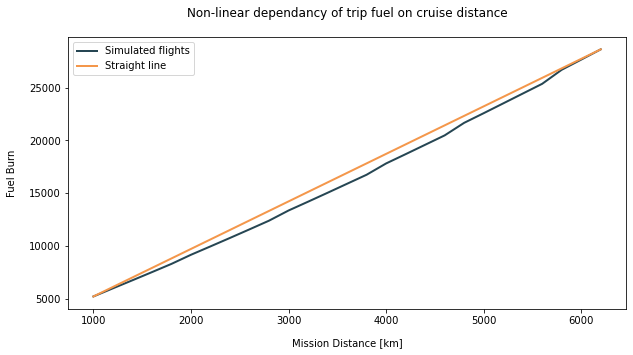

In [34]:
plt.figure(figsize=(10,5))
plt.plot(fuel_burns['distance'],fuel_burns['fuel_burn'],label='Simulated flights')
plt.plot(fuel_burns.iloc[[0,-1]]['distance'],fuel_burns.iloc[[0,-1]]['fuel_burn'],label='Straight line')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Fuel Burn')
plt.title('Non-linear dependancy of trip fuel on cruise distance')
plt.legend();

The above graph shows the same conclusion as for the B738 before

In [35]:
fuel_burns

,distance,tow,fuel_burn
0,1000,77189.908,5198.946
1,1200,77955.722,5969.659
2,1400,78732.635,6733.715
3,1600,79503.575,7505.238
4,1800,80284.406,8286.866
5,2000,81143.466,9151.570
6,2200,81941.397,9946.419
7,2400,82742.110,10748.820
8,2600,83552.589,11561.389
9,2800,84373.135,12384.499


The maximum take-off weight of an A321 is about 83 tons. We see from the fuel burns calculation that the aircraft TOW (take-off weight) is above the MTOW for the aircraft type at distances above 2,400 km. Let's set the MTOW constraint and review the behavior...

In [36]:
fuel_burns = {'distance':[],'tow':[],'fuel_burn':[]}
for distance in np.arange(1000,6400,200):
    diff=21
    fuel_load = 0
    initial_mass = A321.m_ref+fuel_load
    if distance<=2400:
        while abs(diff)>20: #The profile is considered a solution when the TOW difference is less than 20 kg
            profile, notes = simulate_flight(A321,distance,TOW=initial_mass)
            fuel_load = profile_fuel_burn(profile)
            diff = initial_mass - (A321.m_ref+fuel_load)
            initial_mass = A321.m_ref+fuel_load
    else:
        profile, notes = simulate_flight(A321,distance,TOW=A321.m_max)
        fuel_load = profile_fuel_burn(profile)
    fuel_burns['distance'].append(distance)
    fuel_burns['tow'].append(profile.mass.max())
    fuel_burns['fuel_burn'].append(fuel_load)
fuel_burns = pd. DataFrame(fuel_burns)

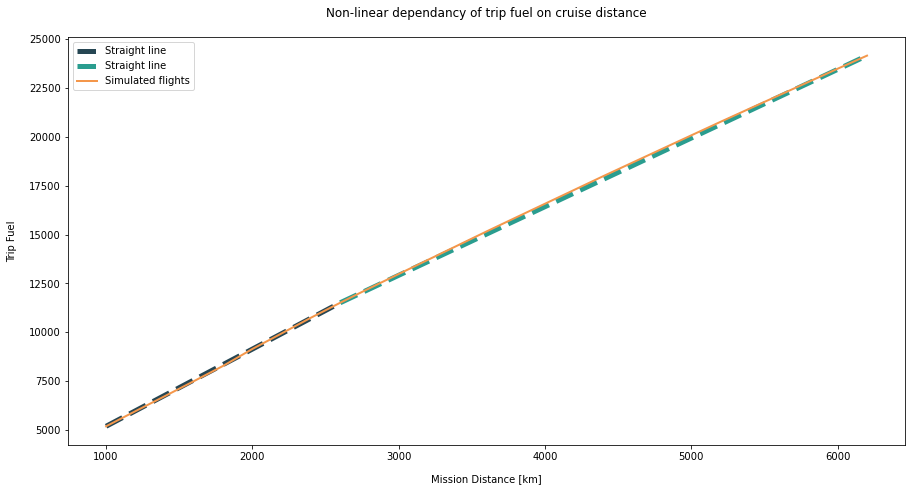

In [37]:
plt.figure(figsize=(15,7.5))
plt.plot(fuel_burns.iloc[[0,8]]['distance'],fuel_burns.iloc[[0,8]]['fuel_burn'],label='Straight line',linestyle='--',linewidth=5,c='C0')
plt.plot(fuel_burns.iloc[[8,-1]]['distance'],fuel_burns.iloc[[8,-1]]['fuel_burn'],label='Straight line',linestyle='--',linewidth=5,c='C3')
plt.plot(fuel_burns['distance'],fuel_burns['fuel_burn'],label='Simulated flights',linewidth=2,c='C1')
plt.xlabel('Mission Distance [km]')
plt.ylabel('Trip Fuel')
plt.title('Non-linear dependancy of trip fuel on cruise distance')
plt.legend();

In [38]:
fuel_burns

,distance,tow,fuel_burn
0,1000,77189.908,5198.946
1,1200,77955.722,5969.659
2,1400,78732.635,6733.715
3,1600,79503.575,7505.238
4,1800,80284.406,8286.866
5,2000,81143.466,9151.570
6,2200,81941.397,9946.419
7,2400,82742.110,10748.820
8,2600,83000.000,11512.577
9,2800,83000.000,12255.101


The above graph shows that the fuel load increases at a very slightly increasing rate (upward curve) as the mission distance increases up the the distance where the TOW is constrained to the maximum (2,600 km). This is due to the increasing fuel load. Then, the fuel load increases with a slightly decreasing rate (downward curve) with mission distance. This is due to the reduced cruise fuel flow rate effect.

### Final Reduced Order Model Summary

Now let's look at the final reduced order model for this aircraft...

In [39]:
A321 = AircraftModel('A321')

In [40]:
generate_reduced_model(A321,25)

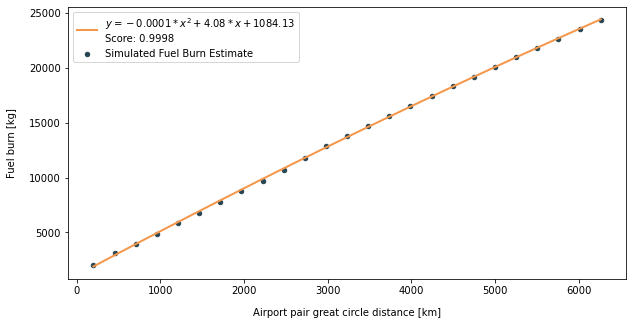

In [41]:
reduced_model_ac_viewer(A321)

While the B738 model had an upward curve, the A321 model has a downward curve. This is due to the fact that, as can be seen from the plot before, there are two competing behaviors which affect the shape of the line. The behavior below a critical mission distance (around 2,600 km) "competes" for an upward curve due to the increased fuel effect, while the behavior above the critical mission distance "competes" for a downward curve. This is due to the fact that for increasing cruise intervals (longer mission distances), the average cruise fuel consumption decreases since the aircraft mass (and subsequently drag) decreases throughout the flight. In the end, as there are more points above the critical mission distance than below, the downward curve has a larger impact on the regression calculation and the final resulting line has a somewhat downward curve.


## A346

Generate a reduced order model for an A346 but this time use a more realistic TOW estimation

In [42]:
A346 = AircraftModel('A346')

### Fuel Payload Effect

Let's take a look at the payload effect again but this time use a more realistic aircraft zero fuel weight (ZFW) instead of the BADA reference mass. We calculate the ZFW from the aircraft operating empty weight, available seats, load factor (81.9%), and passenger-to-freight factor (85.1%).

In [43]:
ac_datasets = get_ac_datasets()
zfw = A346.m_min+round(ac_datasets['seat_caps'].at['A346','seats']*81.9,0)*100/85.1
print('We will use {:,.0f} kg instead of the BADA refence mass for the zfw of this aircraft.'.format(zfw))

We will use 203,667 kg instead of the BADA refence mass for the zfw of this aircraft.


In [44]:
fuel_burns = {'distance':[],'tow':[],'fuel_burn':[]}
for distance in np.arange(1000,12400,400):
    diff=21
    fuel_load = 0
    initial_mass = zfw+fuel_load
    while abs(diff)>20:#The profile is considered a solution when the TOW difference is less than 20 kg
        profile, notes = simulate_flight(A346,distance,TOW=initial_mass)
        fuel_load = profile_fuel_burn(profile)
        diff = initial_mass - (zfw+fuel_load)
        initial_mass = zfw+fuel_load
    fuel_burns['distance'].append(distance)
    fuel_burns['tow'].append(profile.mass.max())
    fuel_burns['fuel_burn'].append(fuel_load)
fuel_burns = pd. DataFrame(fuel_burns)

In [45]:
fuel_burns

,distance,tow,fuel_burn
0,1000,215822.566027,12166.651
1,1400,218954.965027,15288.916
2,1800,222100.642027,18435.803
3,2200,225290.127027,21627.444
4,2600,228495.525027,24836.151
5,3000,231755.112027,28100.829
6,3400,235021.591027,31374.258
7,3800,238381.099027,34717.907
8,4200,241718.536027,38060.450
9,4600,245126.662027,41472.740


The maximum MTOW (maximum take-off weight) of an A346 is about 380 tons. We see from the fuel burns calculation that the aircraft TOW (take-off weight) never surpasses the MTOW for the aircraft type. Thus, the MTOW constraint does not effect the model curve and we end up with a purely upward curve.

### Final Reduced Order Model Summary

Let's look at the final reduced order model for this aircraft...

In [46]:
A346 = AircraftModel('A346')
generate_reduced_model(A346,25)

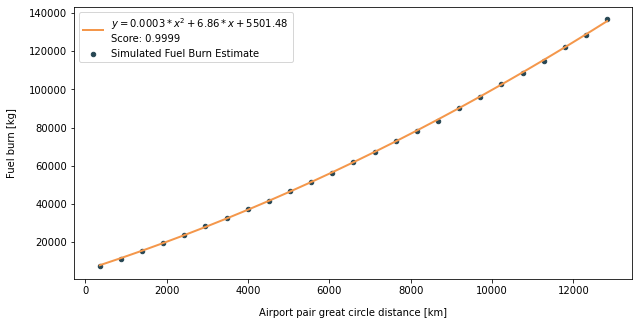

In [47]:
reduced_model_ac_viewer(A346)

As mentioned before, since this aircraft type doesn't reach the MTOW constraint, the effect of increasing fuel consumption from higher fuel load is present throughout the entire range of mission distances. In this case, the reduced order regression curve has a very consistent upward curve.

## B773

Generate a reduced order model for a B773 using the BADA reference mass as the TOW and investigate its shape.

In [48]:
B773 = AircraftModel('B773')
generate_reduced_model(B773,25)

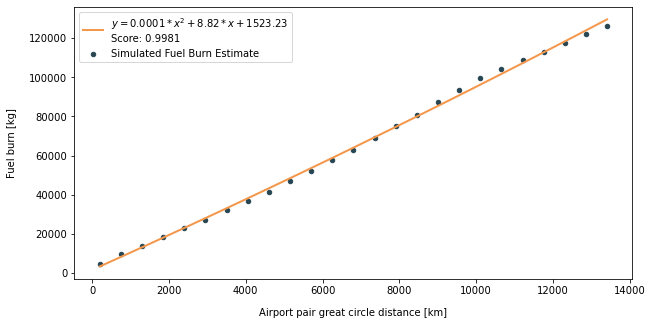

In [49]:
reduced_model_ac_viewer(B773)

In this case, the reduced order regression curve falls below the sample points at missions below about 2,000 km. This is the opposite behavior as for the B738, in which the reduced order model tends to overpredict fuel consuption at low mission ranges.

In [50]:
B773_extended_samples = B773.reduced_model_samples[B773.reduced_model_samples.distance>2000].copy()
extension = {'distance':[],'fuel_burn':[]}
for distance in np.arange(100,2100,100):
#     if distance = 200:
        profile,notes = simulate_flight(B773,distance)
        extension['distance'].append(distance)
        extension['fuel_burn'].append(profile_fuel_burn(profile))
B773_extended_samples = B773_extended_samples.append(pd.DataFrame(extension),sort=False)
B773_extended_samples = B773_extended_samples.sort_values('distance').reset_index(drop=True)

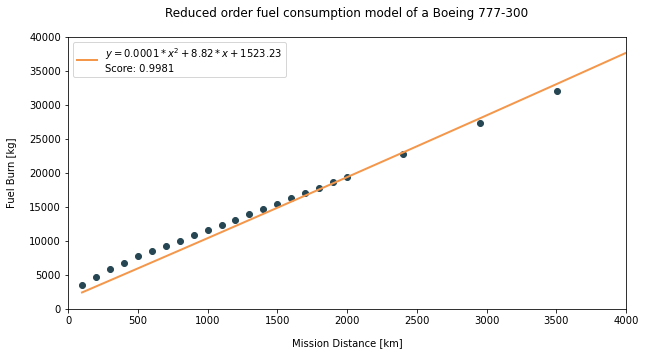

In [51]:
plt.figure(figsize=(10,5))
x_B773 = B773_extended_samples.distance
y_B773 = B773_extended_samples.fuel_burn
plt.scatter(x_B773,y_B773)
a1 = B773.reduced_fuel_a1.item()
a2 = B773.reduced_fuel_a2.item()
intercept = B773.reduced_fuel_intercept.item()
y_est_B773 = a1*x_B773**2 + a2*x_B773 + intercept
plt.plot(x_B773,y_est_B773,c='C1',label='$y={:.4f}*x^2+{:.2f}*x+{:.2f}$\nScore: {:.4f}'.format(a1,a2,intercept,B773.reduced_fuel_score.item()))
plt.xlim(0,4000)
plt.ylim(0,40000)
plt.ylabel('Fuel Burn [kg]')
plt.xlabel('Mission Distance [km]')
plt.title('Reduced order fuel consumption model of a Boeing 777-300')
plt.legend();

In [52]:
dist = 100
sample = B773_extended_samples.loc[B773_extended_samples.distance==100,'fuel_burn'].item()
a1 = B773.reduced_fuel_a1.item()
a2 = B773.reduced_fuel_a2.item()
intercept = B773.reduced_fuel_intercept.item()
est = a1*dist**2 + a2*dist + intercept
error = (est-sample)/sample*100
print('---\nFor mission distances below around 500 km, the percent error of the reduced order model is quite high ({:.1f}% at {:.0f} km). However, as long-haul aircraft like the B777-300 do not typically fly routes of such short distance, the consequence in terms of global fuel consumption modeling is low.\n---'.format(error,dist))

---
For mission distances below around 500 km, the percent error of the reduced order model is quite high (-31.6% at 100 km). However, as long-haul aircraft like the B777-300 do not typically fly routes of such short distance, the consequence in terms of global fuel consumption modeling is low.
---


# Take-Off Weight Sensitivity

We assume a global average load factor for all flights equal to 81.9 (from IATA economic report 2019) and a passenger-to-freight factor of 85.1. In reality, these numbers could be quite different. Thus let us explore the sensitivity of the fuel burn estimates to these parameters...

## Load Factor Sensitivity

### B738

Generate three aircraft models with the load factor parameters set to 81.9, 71.9, or 91.9...

In [53]:
B738_lf_standard = AircraftModel('B738',**{'load_factor': 81.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
B738_lf_high = AircraftModel('B738',**{'load_factor': 91.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
B738_lf_low = AircraftModel('B738',**{'load_factor': 71.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
lf_dependent_fuel_burn_B738 = {'distance':[],'low':[],'standard':[],'high':[]}
for distance in np.arange(1000,5500,500):
    lf_dependent_fuel_burn_B738['distance'].append(distance)
    profile,notes = simulate_flight(B738_lf_low,distance)
    lf_dependent_fuel_burn_B738['low'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(B738_lf_standard,distance)
    lf_dependent_fuel_burn_B738['standard'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(B738_lf_high,distance)
    lf_dependent_fuel_burn_B738['high'].append(profile_fuel_burn(profile))
lf_dependent_fuel_burn_B738 = pd.DataFrame(lf_dependent_fuel_burn_B738)

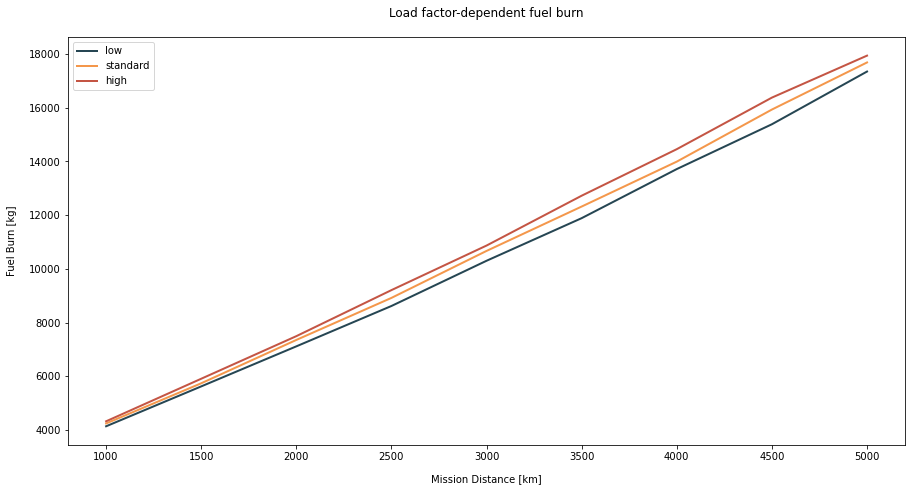

In [54]:
lf_dependent_fuel_burn_B738.plot(x='distance',y=['low','standard','high'],figsize=(15,7.5))
plt.xlabel('Mission Distance [km]')
plt.ylabel('Fuel Burn [kg]')
plt.title('Load factor-dependent fuel burn');

In the above case, the effect of load factor on fuel burn is visible but the impact is relatively small...

In [55]:
_ = lf_dependent_fuel_burn_B738.copy()
print('For a 1,500 km mission distance, the low load factor (71.9) reduces fuel consumption by {:.1f}% \nand the high load factor (91.9) increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==1500,'standard'].item()-_.loc[_.distance==1500,'low'].item())/_.loc[_.distance==1500,'standard'].item()*100,(_.loc[_.distance==1500,'high'].item()-_.loc[_.distance==1500,'standard'].item())/_.loc[_.distance==1500,'standard'].item()*100))
print('For a 3,000 km mission distance, the low load factor (71.9) reduces fuel consumption by {:.1f}% \nand the high load factor (91.9) increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==3000,'standard'].item()-_.loc[_.distance==3000,'low'].item())/_.loc[_.distance==3000,'standard'].item()*100,(_.loc[_.distance==3000,'high'].item()-_.loc[_.distance==3000,'standard'].item())/_.loc[_.distance==3000,'standard'].item()*100))
print('For a 4,500 km mission distance, the low load factor (71.9) reduces fuel consumption by {:.1f}% \nand the high load factor (91.9) increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==4500,'standard'].item()-_.loc[_.distance==4500,'low'].item())/_.loc[_.distance==4500,'standard'].item()*100,(_.loc[_.distance==4500,'high'].item()-_.loc[_.distance==4500,'standard'].item())/_.loc[_.distance==4500,'standard'].item()*100))

For a 1,500 km mission distance, the low load factor (71.9) reduces fuel consumption by 2.0% 
and the high load factor (91.9) increases fuel consumption by 2.9%
For a 3,000 km mission distance, the low load factor (71.9) reduces fuel consumption by 3.4% 
and the high load factor (91.9) increases fuel consumption by 1.9%
For a 4,500 km mission distance, the low load factor (71.9) reduces fuel consumption by 3.4% 
and the high load factor (91.9) increases fuel consumption by 2.8%


Let's look at a different aircraft...

### A346

In [56]:
A346_lf_standard = AircraftModel('A346',**{'load_factor': 81.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
A346_lf_high = AircraftModel('A346',**{'load_factor': 91.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
A346_lf_low = AircraftModel('A346',**{'load_factor': 71.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
lf_dependent_fuel_burn_A346 = {'distance':[],'low':[],'standard':[],'high':[]}
for distance in np.arange(1000,12100,1000):
    lf_dependent_fuel_burn_A346['distance'].append(distance)
    profile,notes = simulate_flight(A346_lf_low,distance)
    lf_dependent_fuel_burn_A346['low'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(A346_lf_standard,distance)
    lf_dependent_fuel_burn_A346['standard'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(A346_lf_high,distance)
    lf_dependent_fuel_burn_A346['high'].append(profile_fuel_burn(profile))
lf_dependent_fuel_burn_A346 = pd.DataFrame(lf_dependent_fuel_burn_A346)

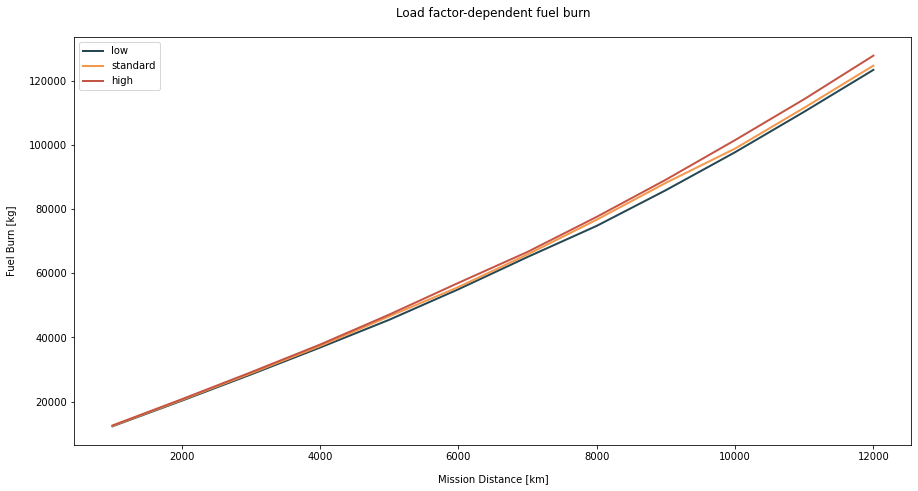

In [57]:
lf_dependent_fuel_burn_A346.plot(x='distance',y=['low','standard','high'],figsize=(15,7.5))
plt.xlabel('Mission Distance [km]')
plt.ylabel('Fuel Burn [kg]')
plt.title('Load factor-dependent fuel burn');

In the above case, the effect of load factor on fuel burn is visible but the impact is also small...

In [58]:
_ = lf_dependent_fuel_burn_A346.copy()
print('For a 2,000 km mission distance, the low load factor (71.9) reduces fuel consumption by {:.1f}% \nand the high load factor (91.9) increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==2000,'standard'].item()-_.loc[_.distance==2000,'low'].item())/_.loc[_.distance==2000,'standard'].item()*100,(_.loc[_.distance==2000,'high'].item()-_.loc[_.distance==2000,'standard'].item())/_.loc[_.distance==2000,'standard'].item()*100))
print('For a 8,000 km mission distance, the low load factor (71.9) reduces fuel consumption by {:.1f}% \nand the high load factor (91.9) increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==8000,'standard'].item()-_.loc[_.distance==8000,'low'].item())/_.loc[_.distance==8000,'standard'].item()*100,(_.loc[_.distance==8000,'high'].item()-_.loc[_.distance==8000,'standard'].item())/_.loc[_.distance==8000,'standard'].item()*100))
print('For a 11,000 km mission distance, the low load factor (71.9) reduces fuel consumption by {:.1f}% \nand the high load factor (91.9) increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==11000,'standard'].item()-_.loc[_.distance==11000,'low'].item())/_.loc[_.distance==11000,'standard'].item()*100,(_.loc[_.distance==11000,'high'].item()-_.loc[_.distance==11000,'standard'].item())/_.loc[_.distance==11000,'standard'].item()*100))

For a 2,000 km mission distance, the low load factor (71.9) reduces fuel consumption by 1.1% 
and the high load factor (91.9) increases fuel consumption by 1.1%
For a 8,000 km mission distance, the low load factor (71.9) reduces fuel consumption by 2.5% 
and the high load factor (91.9) increases fuel consumption by 1.2%
For a 11,000 km mission distance, the low load factor (71.9) reduces fuel consumption by 1.1% 
and the high load factor (91.9) increases fuel consumption by 2.4%


## Passenger-to-Freight Factor Sensitivity

### B738

Generate three aircraft models with the passenger-to-freight parameters set to 85.1, 75.1, or 95.1...

In [59]:
B738_ptf_standard = AircraftModel('B738',**{'load_factor': 81.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
B738_ptf_high = AircraftModel('B738',**{'load_factor': 81.9,'ptf_factor': 95.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
B738_ptf_low = AircraftModel('B738',**{'load_factor': 81.9,'ptf_factor': 75.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
ptf_dependent_fuel_burn_B738 = {'distance':[],'low':[],'standard':[],'high':[]}
for distance in np.arange(1000,5500,500):
    ptf_dependent_fuel_burn_B738['distance'].append(distance)
    profile,notes = simulate_flight(B738_ptf_low,distance)
    ptf_dependent_fuel_burn_B738['low'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(B738_ptf_standard,distance)
    ptf_dependent_fuel_burn_B738['standard'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(B738_ptf_high,distance)
    ptf_dependent_fuel_burn_B738['high'].append(profile_fuel_burn(profile))
ptf_dependent_fuel_burn_B738 = pd.DataFrame(ptf_dependent_fuel_burn_B738)

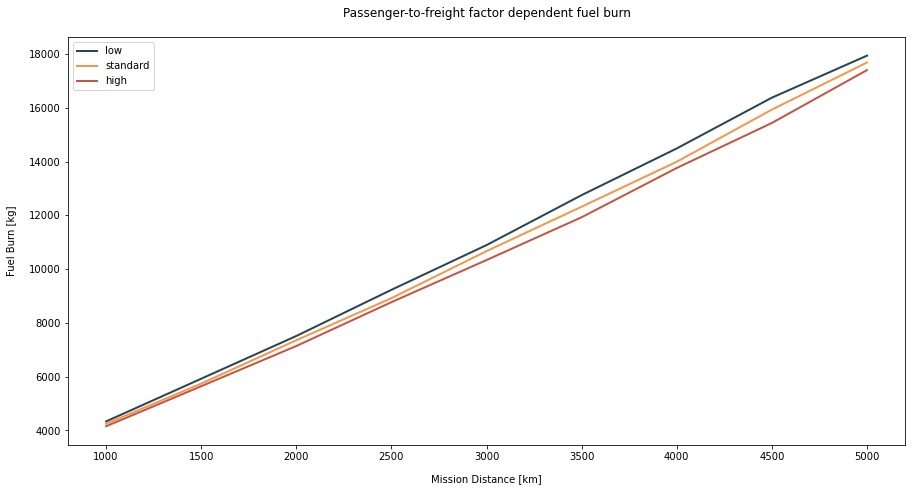

In [60]:
ptf_dependent_fuel_burn_B738.plot(x='distance',y=['low','standard','high'],figsize=(15,7.5))
plt.xlabel('Mission Distance [km]')
plt.ylabel('Fuel Burn [kg]')
plt.title('Passenger-to-freight factor dependent fuel burn');

In [61]:
_ = ptf_dependent_fuel_burn_B738.copy()
print('For a 1,500 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by {:.1f}% \nand the high passenger-to-freight factor (95.1) increases fuel consumption by {:.1f}%'.format(-(_.loc[_.distance==1500,'standard'].item()-_.loc[_.distance==1500,'low'].item())/_.loc[_.distance==1500,'standard'].item()*100,-(_.loc[_.distance==1500,'high'].item()-_.loc[_.distance==1500,'standard'].item())/_.loc[_.distance==1500,'standard'].item()*100))
print('For a 3,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by {:.1f}% \nand the high passenger-to-freight factor (95.1) increases fuel consumption by {:.1f}%'.format(-(_.loc[_.distance==3000,'standard'].item()-_.loc[_.distance==3000,'low'].item())/_.loc[_.distance==3000,'standard'].item()*100,-(_.loc[_.distance==3000,'high'].item()-_.loc[_.distance==3000,'standard'].item())/_.loc[_.distance==3000,'standard'].item()*100))
print('For a 4,500 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by {:.1f}% \nand the high passenger-to-freight factor (95.1) increases fuel consumption by {:.1f}%'.format(-(_.loc[_.distance==4500,'standard'].item()-_.loc[_.distance==4500,'low'].item())/_.loc[_.distance==4500,'standard'].item()*100,-(_.loc[_.distance==4500,'high'].item()-_.loc[_.distance==4500,'standard'].item())/_.loc[_.distance==4500,'standard'].item()*100))

For a 1,500 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by 3.2% 
and the high passenger-to-freight factor (95.1) increases fuel consumption by 1.7%
For a 3,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by 2.1% 
and the high passenger-to-freight factor (95.1) increases fuel consumption by 3.1%
For a 4,500 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by 2.8% 
and the high passenger-to-freight factor (95.1) increases fuel consumption by 3.1%


### A346

In [62]:
A346_ptf_standard = AircraftModel('A346',**{'load_factor': 81.9,'ptf_factor': 85.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
A346_ptf_high = AircraftModel('A346',**{'load_factor': 81.9,'ptf_factor': 95.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
A346_ptf_low = AircraftModel('A346',**{'load_factor': 81.9,'ptf_factor': 75.1,'oew_factor': 1.0,'gr_factor': 1.0,'tsfc_factor': 1.0})
ptf_dependent_fuel_burn_A346 = {'distance':[],'low':[],'standard':[],'high':[]}
for distance in np.arange(1000,12100,1000):
    ptf_dependent_fuel_burn_A346['distance'].append(distance)
    profile,notes = simulate_flight(A346_ptf_low,distance)
    ptf_dependent_fuel_burn_A346['low'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(A346_ptf_standard,distance)
    ptf_dependent_fuel_burn_A346['standard'].append(profile_fuel_burn(profile))
    profile,notes = simulate_flight(A346_ptf_high,distance)
    ptf_dependent_fuel_burn_A346['high'].append(profile_fuel_burn(profile))
ptf_dependent_fuel_burn_A346 = pd.DataFrame(ptf_dependent_fuel_burn_A346)

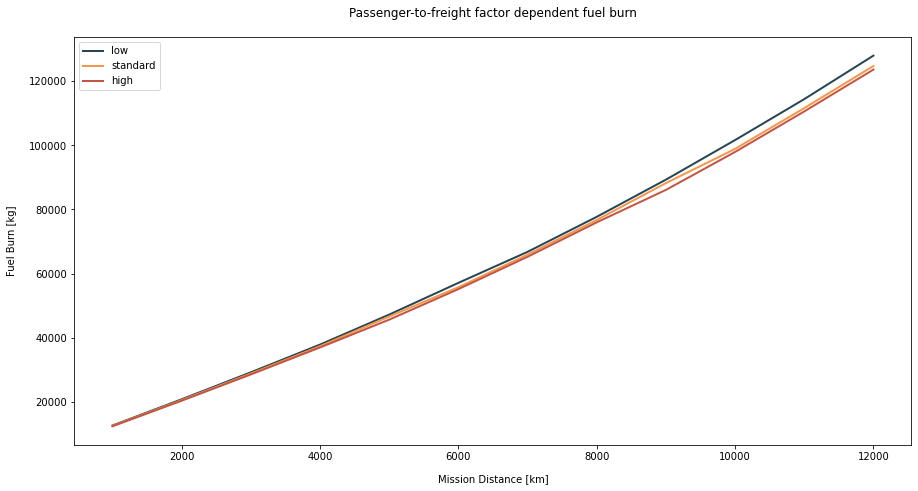

In [63]:
ptf_dependent_fuel_burn_A346.plot(x='distance',y=['low','standard','high'],figsize=(15,7.5))
plt.xlabel('Mission Distance [km]')
plt.ylabel('Fuel Burn [kg]')
plt.title('Passenger-to-freight factor dependent fuel burn');

In the above case, the effect of load factor on fuel burn is visible but the impact is small...

In [64]:
_ = ptf_dependent_fuel_burn_A346.copy()
print('For a 2,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by {:.1f}% \nand the high (0.9) passenger-to-freight factor increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==2000,'low'].item()-_.loc[_.distance==2000,'standard'].item())/_.loc[_.distance==2000,'standard'].item()*100,(_.loc[_.distance==2000,'standard'].item()-_.loc[_.distance==2000,'high'].item())/_.loc[_.distance==2000,'standard'].item()*100))
print('For a 8,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by {:.1f}% \nand the high (0.9) passenger-to-freight factor increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==8000,'low'].item()-_.loc[_.distance==8000,'standard'].item())/_.loc[_.distance==8000,'standard'].item()*100,(_.loc[_.distance==8000,'standard'].item()-_.loc[_.distance==8000,'high'].item())/_.loc[_.distance==8000,'standard'].item()*100))
print('For a 11,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by {:.1f}% \nand the high (0.9) passenger-to-freight factor increases fuel consumption by {:.1f}%'.format((_.loc[_.distance==11000,'low'].item()-_.loc[_.distance==11000,'standard'].item())/_.loc[_.distance==11000,'standard'].item()*100,(_.loc[_.distance==11000,'standard'].item()-_.loc[_.distance==11000,'high'].item())/_.loc[_.distance==11000,'standard'].item()*100))

For a 2,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by 1.2% 
and the high (0.9) passenger-to-freight factor increases fuel consumption by 0.9%
For a 8,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by 1.3% 
and the high (0.9) passenger-to-freight factor increases fuel consumption by 1.0%
For a 11,000 km mission distance, the low passenger-to-freight factor (75.1) reduces fuel consumption by 2.5% 
and the high (0.9) passenger-to-freight factor increases fuel consumption by 0.9%
